## Exploratory Data Analysis del Caso base (para regiones)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp, quad
import numpy as np
from scipy.misc import derivative as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
γ = 1/2.4
fecha_inicio = pd.to_datetime("27-february-2020")
r = 0.7
red_traf = r
inicio_red = 25
f = 0.9
q = 0.1356473594548552
ν = 5/12
η = 1/7
ϵ = 1/1.4
θ = 1/2.4
pa, pm, ps = 0.5, 0.476, 0.024
σ = 1/4.7
ξ = 1/4
τ = 1/5

## Defunciones

In [3]:
defun = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_reg.csv",
           index_col = 0);
acumdefun = defun.cumsum(axis = 1).iloc[:, :75]

In [35]:
pob = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_reg.csv", index_col = 0)

In [37]:
pob = pob['pop'].to_list()

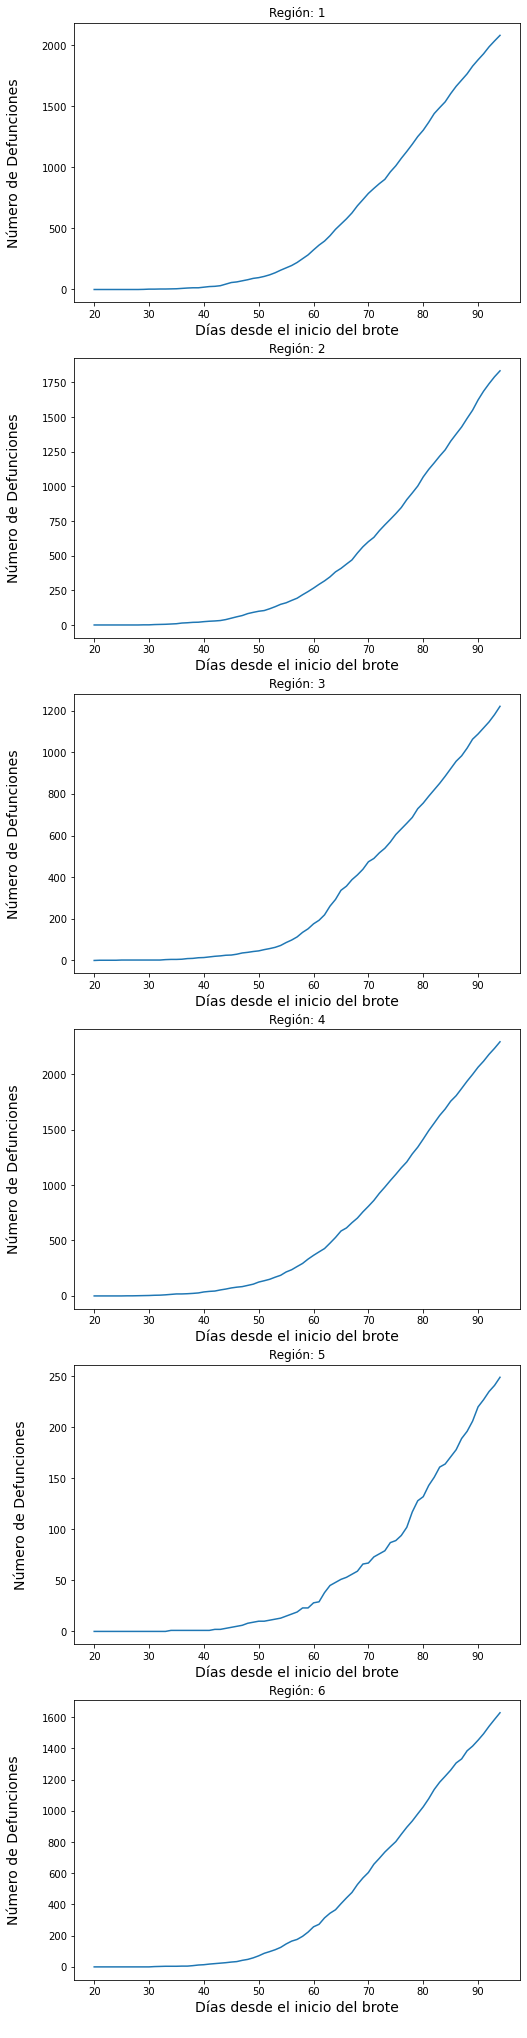

In [14]:
fig, ax = plt.subplots(6, figsize = (8, 36))

for i in range(6):
    ax[i].plot(range(20, 95), acumdefun.iloc[i])
    ax[i].set_title('Región: {}'.format(i+1))
    ax[i].set_ylabel('Número de Defunciones\n', fontsize = 14)
    ax[i].set_xlabel('Días desde el inicio del brote\n', fontsize = 14)

Parece que se le puede ajustar una curva logísitca de la forma $f(x) = A + \frac{(K-A)}{C+Qe^{-B(t+t0) + J}}$. Habiendo inspeccionado todas las series del tiempo, hay algunas que no se ajustan bien (tienen muy pocos casos y hay un brinco tipo función escalera), suponemos que en estas ciudades no se registraron casos.

In [15]:
D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))

In [16]:
paramsD = []

for i in range(47):

    try:
        y = acumdefun.iloc[i, :75]
        fit = optimize.curve_fit(D, list(range(20, 95)), y, maxfev=1000)[0]
        paramsD.append(fit)
    except: # los que no se ajustan bien tienen ínidces 17, 28
        paramsD.append([0, 1, 0, 0, 0])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_9604\2150841193.py:1: RuntimeWarning: overflow encountered in exp
  D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Veamos cómo se ajusta nuestro modelo de defunciones:

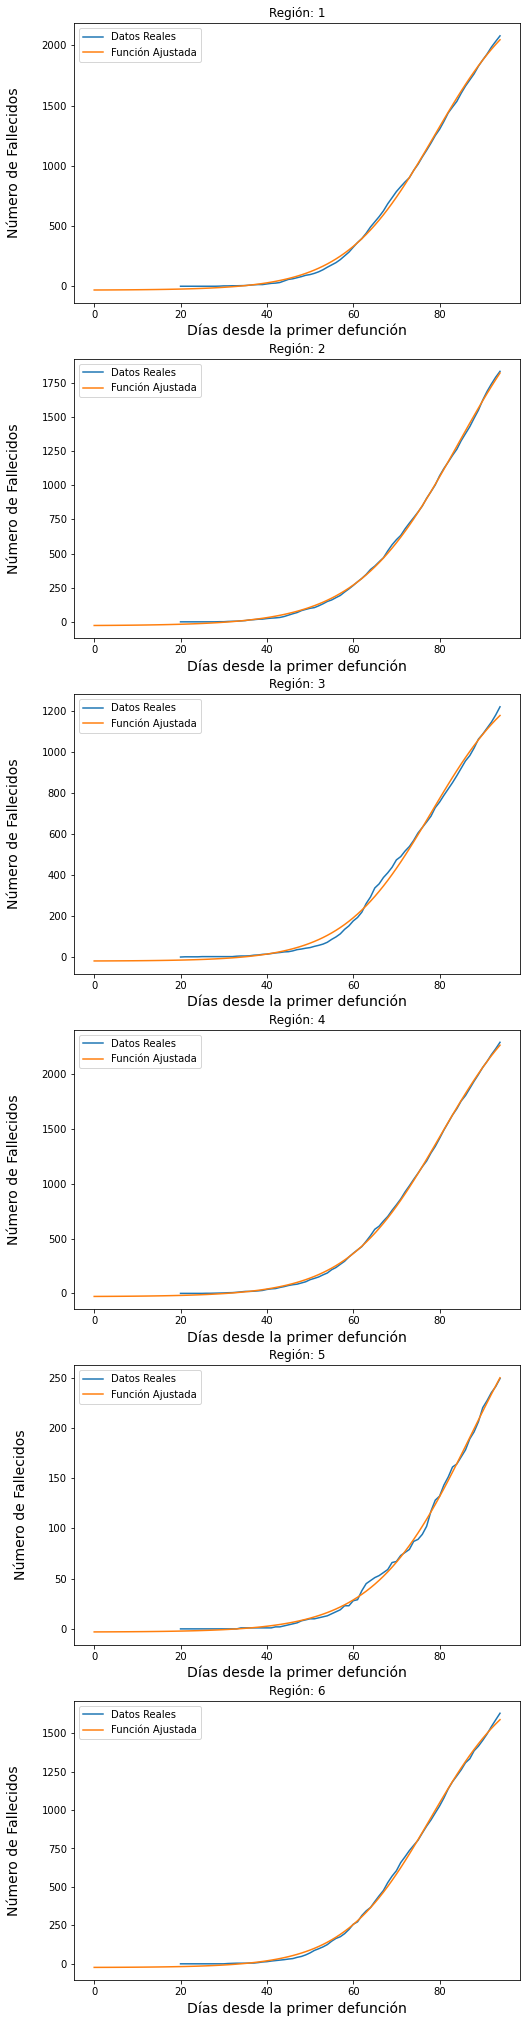

In [17]:
fig, ax = plt.subplots(6, figsize = (8, 36))
t = np.array(range(95))

for i in range(6):
    ax[i].plot(range(20, 95), acumdefun.iloc[i], label = 'Datos Reales')
    ax[i].plot(t, D(t, *paramsD[i]), label = 'Función Ajustada')
    ax[i].set_title('Región: {}'.format(i+1))
    ax[i].set_ylabel('Número de Fallecidos\n', fontsize = 14)
    ax[i].set_xlabel('Días desde la primer defunción\n', fontsize = 14)
    ax[i].legend()

plt.show()

De la ecuación diferencial tenemos que $\frac{dD_i}{dt} = q\xi H_i(t) \Rightarrow H_i(t) = \frac{1}{q\xi}\cdot \frac{dD_i}{dt} $

In [18]:
H = lambda t, i: 1/(q*ξ) * dt(D, t, n=1, args = (*paramsD[i], ))

Además, $\frac{dH_i}{dt} = \sigma I_{ss_i} - q\xi H_i - (1-q)\tau H_i \Rightarrow I_{ss_i}(t) = \frac{1}{\sigma}\left(\frac{dH_i}{dt} + \left(q\xi + (1-q)\tau\right)H_i \right)$

In [19]:
Iss = lambda t, i : (dt(H, t, n=1, args = (i,)) + (q*ξ + (1-q)*τ)*H(t, i))/σ

Luego, $\frac{dI_{ss_i}}{dt} = \theta p_s I_{p_i} - \sigma I_{ss_i}$, de donde $I_{p_i}(t) = \frac{1}{\theta p_s}\left(\frac{dI_{ss_i}}{dt} + \sigma I_{ss_i} \right)$

In [20]:
Ip = lambda t, i: 1/(θ*ps)*(dt(Iss, t, n=1, args = (i, )) + σ*Iss(t, i))

In [22]:
Ip0 = [int(Ip(0, i)) for i in range(6)]

Luego $\frac{dI_{p_i}}{dt} = \epsilon E_i(t) - \theta I_{p_i}$

$E_i(t) = \frac{1}{\epsilon}\left(\frac{dI_{p_i}}{dt}+\theta I_{p_i}\right)$

In [23]:
E = lambda t, i: 1/(ϵ)*(dt(Ip, t, n=1, args = (i, )) + θ*Ip(t, i))

In [24]:
E0 = [int(E(0, i)) for i in range(6)]

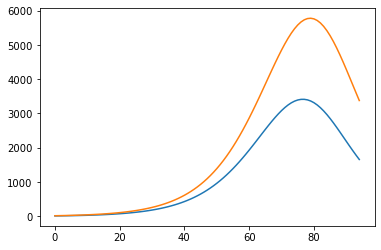

In [29]:
t = np.array(range(95))
plt.plot(t, E(t, 4))
plt.plot(t, Ip(t, 4))

plt.show()

$\frac{dE_i}{dt}=\lambda_i(t)S_i(t) - \epsilon E_i$

$\frac{dE_i}{dt}= -\frac{dS_i}{dt} - \epsilon E_i$

$\frac{dS_i}{dt}=-\epsilon E_i - \frac{dE_i}{dt}$

$-\epsilon E_i - \frac{dE_i}{dt} = -\lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\epsilon E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

$S_i(\tau) - S_i(0) = - \epsilon \displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + E_i(0)$

$S_i(\tau) = -\epsilon\displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + S_i(0)$

In [38]:
S = lambda t, i: -ϵ*quad(E, 0, t, args = (i, ))[0] - E(t,i) + (pob[i] - Ip0[i])

In [39]:
T = np.array(range(95))

In [40]:
Sarray = np.zeros((6, 95))

In [41]:
for i in range(6):
    Sarray[i] = [S(t, i) for t in T]

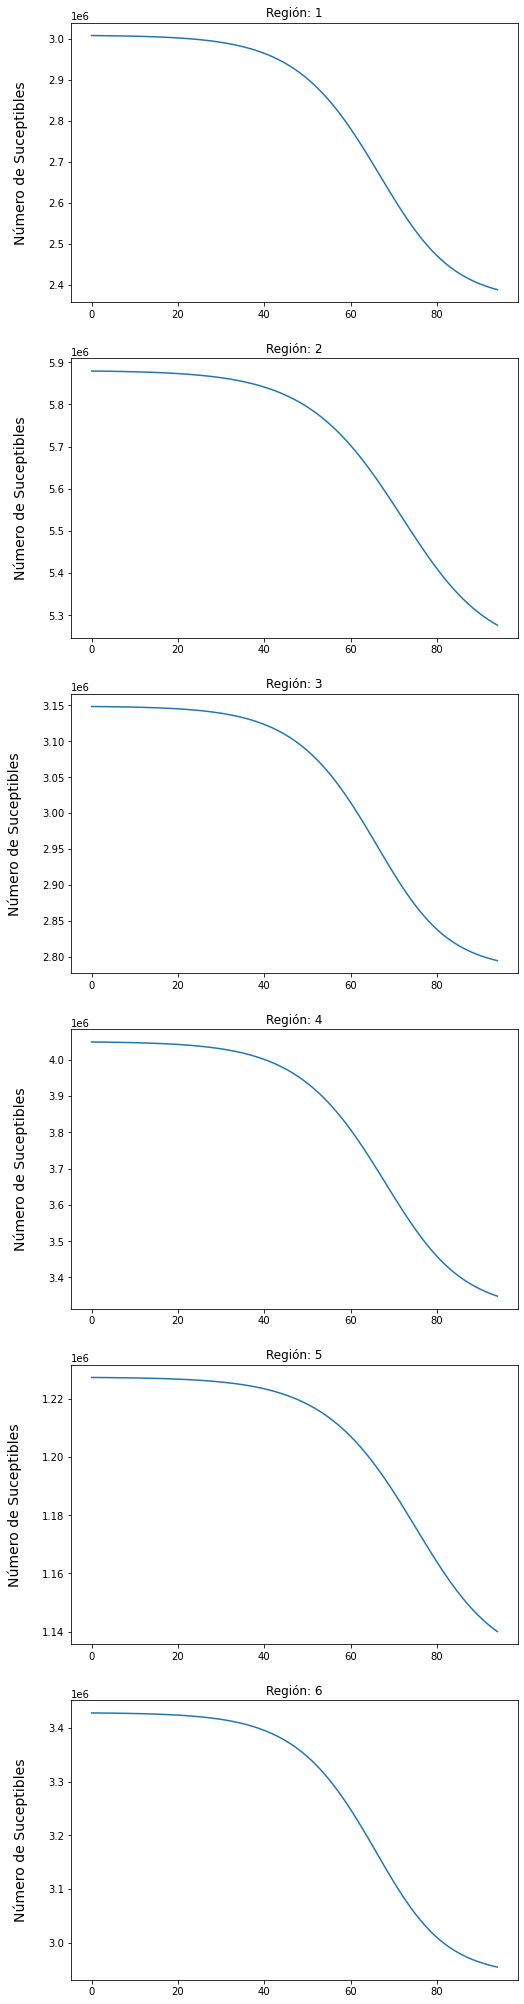

In [42]:
fig, ax = plt.subplots(6, figsize = (8, 36))

t = np.array(range(95))

for i in range(6):
    ax[i].plot(t, Sarray[i])
    ax[i].set_title('Región: {}'.format(i+1))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)

Para el resto de los infectados, podemos resolver sus ecuaciones diferenciales de manera numérica:

In [43]:
def IaEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(6)
    
    Ia = lambda i: X[i]
            
    for i in range(6):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pa*Ip(t, i) - γ*Ia(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Ia0 = np.zeros(6)
indicesCasos = [0, 5]
Ia0[indicesCasos] = 1


solIa = solve_ivp(IaEDO, (0, 94), Ia0, t_eval = tdata)

In [44]:
Ia = lambda t, i: solIa.y[i, np.array(t).astype(int)]

In [45]:
def ImEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(6)
    
    Im = lambda i: X[i]
            
    for i in range(6):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pm*Ip(t, i) - γ*Im(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Im0 = np.zeros(6)

solIm = solve_ivp(ImEDO, (0, 94), Im0, t_eval = tdata)

In [46]:
Im = lambda t, i: solIm.y[i, np.array(t).astype(int)]

$-\epsilon E_i - \frac{dE_i}{dt} = -\lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\epsilon E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

In [47]:
λ = lambda t, i: (dt(E, t, n = 1, args = (i, )) + ϵ*E(t,i) )/ Sarray[i, t]

In [48]:
es = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_es_reg.csv",
                index_col = 0)

s = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_s_reg.csv",
                index_col = 0)

d = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_d_reg.csv",
                index_col = 0)

In [49]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [53]:
dfs = []

for t in range(95):
    wd = (fecha_inicio.weekday() + t) % 7
    if wd == 5:  #sábado
        df = s.copy()
    elif wd == 6: #domingo
        df = d.copy()
    else:
        df = es.copy()
            
    if t > inicio_red:
        df = df.multiply(r)
        
    df['t'] = t
    df['i'] = range(6)
    df['Ia'] = range(6)
    df['Im'] = range(6)
    df['Ip'] = range(6)
    df['y'] = range(6)
    
    for i in range(6):
        df.iloc[i, -4] = Ia(t, i)
        df.iloc[i, -3] = f*Im(t, i)
        df.iloc[i, -2] = Ip(t, i)
        df.iloc[i, -1] = λ(t, i)
        
    dfs.append(df)

In [54]:
main = pd.concat(dfs, axis = 0)

In [55]:
main.head()

,0,1,2,3,4,5,t,i,Ia,Im,Ip,y
region,,,,,,,,,,,,
0,3269688.0,204305.0,178371.0,981489.0,22227.0,235915.0,0,0,1.0,0.0,166.454808,0.000032
1,223347.0,6902201.0,89189.0,1057884.0,106634.0,129464.0,0,1,0.0,0.0,205.782397,0.000020
2,1623521.0,178944.0,4030497.0,401439.0,38628.0,150899.0,0,2,0.0,0.0,89.989202,0.000017
3,1012212.0,1295630.0,364840.0,5776327.0,73523.0,531318.0,0,3,0.0,0.0,205.171995,0.000029
4,24713.0,112592.0,37302.0,65641.0,1443202.0,93721.0,0,4,0.0,0.0,18.649928,0.000009


In [56]:
train_X, test_X, train_Y, test_Y = train_test_split(main.iloc[:, :-1], main.iloc[:, -1], test_size = 0.25, random_state = 42)

In [57]:
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [58]:
Y = rf.predict(main.iloc[:, :-1])

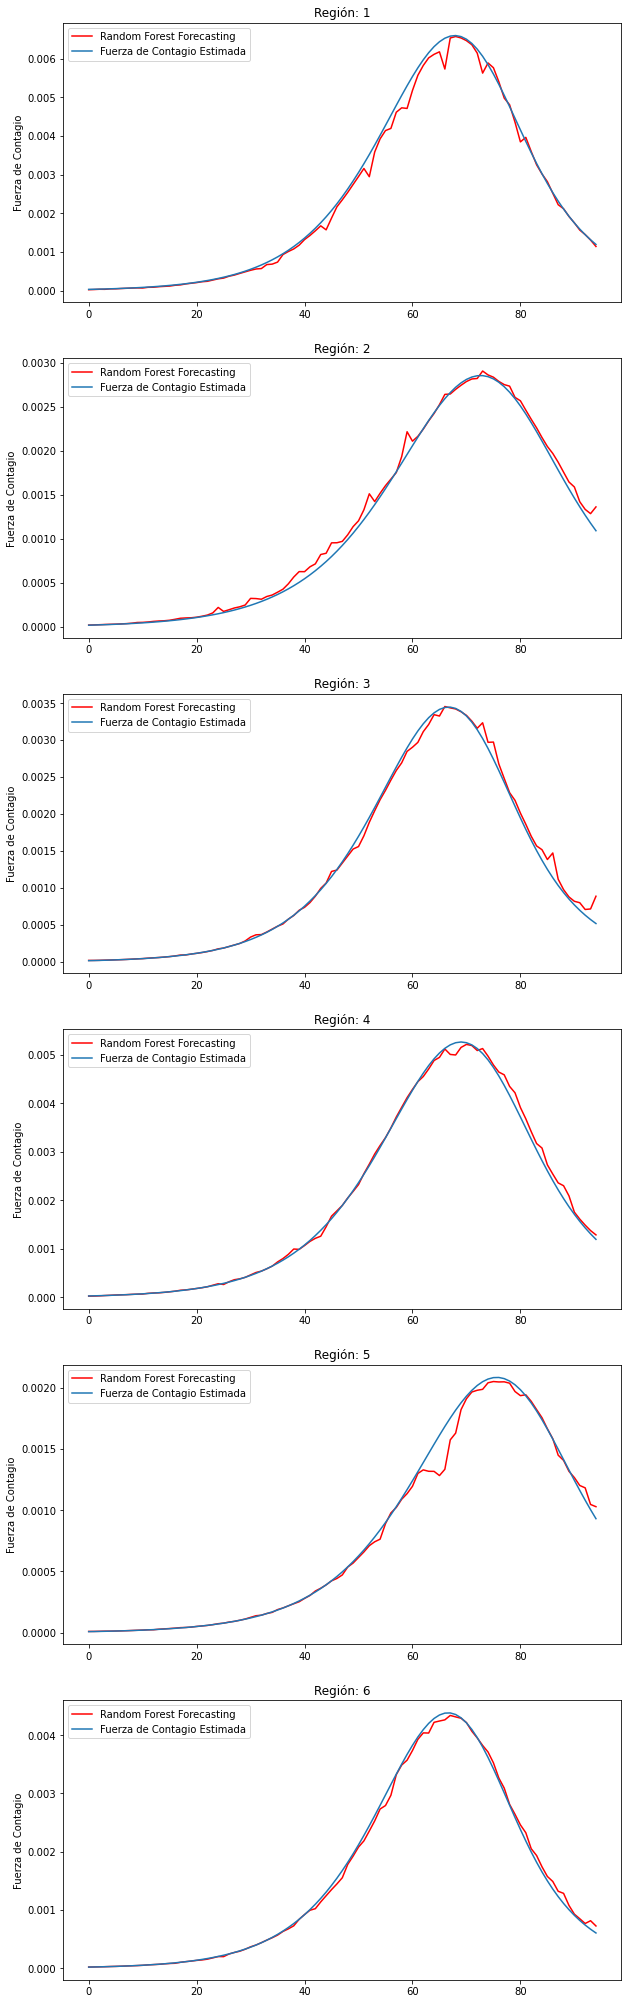

In [100]:
fig, ax = plt.subplots(6, figsize = (10, 36))

t = np.array(range(95))
for k in range(6):
    ax[k].plot(Y[[6*i + k for i in range(95)]], color = 'r', label = 'Random Forest Forecasting')
    ax[k].plot(t, λ(t, k), label = 'Fuerza de Contagio Estimada')
    ax[k].legend()
    ax[k].set_ylabel('Fuerza de Contagio')
    ax[k].set_title('Región: {}'.format(k+1))

In [62]:
main.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/ABTrf_reg.csv")

In [63]:
dfx0 = {'Ip0':Ip0, 'E0': E0}

In [64]:
df = pd.DataFrame(dfx0)

In [65]:
df.index = es.index

In [66]:
df.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/x0_reg.csv")

In [157]:
inicio_red = 25

Intento para ajustar la fuerza de infección del modelo de calveti:

In [67]:
viajes = [es, s, d]

In [159]:
def Q(i):
    if i == 5:
        return 1
    elif i == 6:
        return 2
    else:
        return 0

In [161]:
Q2 = np.vectorize(Q)

In [163]:
J = lambda d, i, j: viajes[int(d)].iloc[i, j]

In [164]:
J2 = np.vectorize(J)

In [165]:
Q2((fecha_inicio.weekday() + np.array(range(95))) % 7)

array([0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2,
       0, 0, 0, 0, 0, 1, 2])

In [173]:
def Ω(i, j, d):
        wd = (fecha_inicio.weekday() + d) % 7
        if wd == 5:
            p = viajes[1].iloc[i, j]
        elif wd == 6:
            p = viajes[2].iloc[i, j]
        else:
            p = viajes[0].iloc[i, j]
        
        if d > inicio_red:
            p = (1-red_traf)* viajes[1].iloc[i, j]
                
        return p

In [167]:
Ω(1, 2, np.array(range(95)))

array([89189, 89189, 96856, 76217, 89189, 89189, 89189, 89189, 89189,
       96856, 76217, 89189, 89189, 89189, 89189, 89189, 96856, 76217,
       89189, 89189, 89189, 89189, 89189, 96856, 76217, 26756, 26756,
       26756, 26756, 26756, 29056, 22865, 26756, 26756, 26756, 26756,
       26756, 29056, 22865, 26756, 26756, 26756, 26756, 26756, 29056,
       22865, 26756, 26756, 26756, 26756, 26756, 29056, 22865, 26756,
       26756, 26756, 26756, 26756, 29056, 22865, 26756, 26756, 26756,
       26756, 26756, 29056, 22865, 26756, 26756, 26756, 26756, 26756,
       29056, 22865, 26756, 26756, 26756, 26756, 26756, 29056, 22865,
       26756, 26756, 26756, 26756, 26756, 29056, 22865, 26756, 26756,
       26756, 26756, 26756, 29056, 22865], dtype=int64)

In [188]:
def λ(Θ, t, i):
    return ν*sum((Θ[k]*np.multiply(Ω(i, k, t), sum((np.multiply(Ω(m, k, t), (Ip(t, m) + Ia(t, m)+f*Im(t, m) / pob[m])) for m in range(6)))) for k in range(6))) + (1-ν)*Θ[i]*(Ip(t, i) + Ia(t, i) + f*Im(t, i))/pob[i]

In [189]:
def Model(t, X, Θ):
    
    dXdt = np.zeros(6*8)
    
    S = lambda i: X[8*i + 0]
    E = lambda i: X[8*i + 1]
    Ip = lambda i: X[8*i + 2]
    Iss =  lambda i: X[8*i + 3]
    H = lambda i: X[8*i + 4]
    Ia = lambda i: X[8*i + 6]
    Im = lambda i: X[8*i + 7]
            
    for i in range(6):    
        # X_i; los componentes de cada ciudad
        # ecuación de los suceptibles para la ciudad i
        dXdt[8*i + 0] = -λ(Θ, t, i)*S(i)
        # ecuación de los expuestos para la ciudad i
        dXdt[8*i + 1] = -dXdt[8*i + 0] - ϵ*E(i)
        # ecuación para los pre-infectados
        dXdt[8*i + 2] = ϵ*E(i) - θ*Ip(i)
        # ecuación para los infectados severos
        dXdt[8*i + 3] = θ*ps*Ip(i) - σ*Iss(i)
        # ecuación para los hospitalizados
        dXdt[8*i + 4] = σ*Iss(i) - (1-q)*τ*H(i) - ξ*q*H(i)
        # ecuación de los difuntos
        dXdt[8*i + 5] = q*ξ*H(i)
        # ecuación de los asintomáticos
        dXdt[8*i + 6] = θ*pa*Ip(i) - γ*Ia(i)
        # ecuación de los mild sym
        dXdt[8*i + 7] = θ*pm*Ip(i) - γ*Im(i)

    return dXdt

In [190]:
x0df = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/x0_reg.csv", index_col = 0)

In [191]:
x0 = []
indicesCasos = [0, 5]

for i in range(6):
    if i in indicesCasos:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1], x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 1, 0])
    else:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1], x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 0, 0])

In [192]:
def sol(Θ, x0):
        """Función que ocupamos para obtener la solución del sistema y que va 
        a ajustarse a los datos."""

        tdata = np.linspace(0, 94, 95)
    
        sol = solve_ivp(Model, (0, 95), x0, args = (Θ,), t_eval = tdata)
        
        #sol = self.__euler(self.__F, self.__x0(), Θ)
    
        return sol.y

In [193]:
casos = pd.read_csv('https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_reg.csv', 
                   index_col = 0)

In [194]:
casos.cumsum(axis = 1).iloc[:, :75]

,17-03-2020,18-03-2020,19-03-2020,20-03-2020,21-03-2020,22-03-2020,23-03-2020,24-03-2020,25-03-2020,26-03-2020,...,21-05-2020,22-05-2020,23-05-2020,24-05-2020,25-05-2020,26-05-2020,27-05-2020,28-05-2020,29-05-2020,30-05-2020
region,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,1602,1662,1713,1764,1827,1879,1928,1985,2033,2079
1,0,0,0,0,0,0,0,0,0,1,...,1325,1377,1428,1490,1549,1623,1686,1740,1790,1833
2,0,1,1,1,1,2,2,2,2,2,...,921,957,983,1020,1063,1088,1117,1146,1181,1221
3,0,0,0,0,0,0,1,1,2,3,...,1755,1805,1870,1936,1997,2062,2116,2178,2232,2291
4,0,0,0,0,0,0,0,0,0,0,...,171,178,189,196,206,220,227,235,241,249
5,0,0,0,0,0,0,0,0,0,0,...,1261,1307,1333,1385,1415,1453,1494,1542,1586,1629


In [195]:
def ajustar(estimados = None):

    def getdata(tn):
        """Obtiene una matriz con los muertos de cada ciudad, donde cada columna es una ciudad distinta y tn es 
        el número de días a analizar."""
        data = np.zeros((6, tn-20))
        for k in range(6):
            # queremos los primeros tn casos de la ciudad k
            # suma acumulada de las defunciones, queremos los tn - 20 primeros días
            data[k] = casos.cumsum(axis = 1).iloc[k, :tn-20]
        return data

    # obtenemos los datos
    data = getdata(95)

    def residual(Θ):
        """Función a optimizar."""
        model = sol(Θ, x0)
        # obtenemos las soluciones de los I_k
        modelI = np.zeros( (6, 95))
        # extraemos estos valores
        for k in range(6):
            # obtenemos las soluciones correspondientes a los Dinfuntos
            modelI[k] = model[8*k + 4]
            # las defunciones empezaron a registrarse a partir del vigésimo día de registrarse la primer infección
        return (modelI[:, 20:] - data).ravel()

        # creamos un vector con los valores estimados iniciales
    g0 = estimados
    if not estimados:
        g0 = []
        g0.extend([0.5]*8)
    # ajustamos
    ajuste = optimize.least_squares(residual, g0, bounds = ([0]*8, [1]*8) )
        #ajuste = least_squares(residual, g0, bounds = ([0]*(self.size+1), [1]*(self.size+1))) 
    return ajuste.x # mu, Br

In [ ]:
ajuste = ajustar()